In [2]:
!pip install torch===1.7.0 torchvision===0.8.1 torchaudio===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached https://download.pytorch.org/whl/cu102/torch-1.7.0-cp38-cp38-win_amd64.whl (1282.4 MB)
  Using cached https://download.pytorch.org/whl/cu102/torchvision-0.8.1-cp38-cp38-win_amd64.whl (1.5 MB)
  Using cached https://download.pytorch.org/whl/torchaudio-0.7.0-cp38-none-win_amd64.whl (103 kB)
  Using cached dataclasses-0.6-py3-none-any.whl (14 kB)
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491062 sha256=6d55f888a454ed9f621a3d2e86c9e6dd70ba554e0bc338690bf7aa2051728940
  Stored in directory: c:\users\freon\appdata\local\pip\cache\wheels\8e\70\28\3d6ccd6e315f65f245da085482a2e1c7d14b90b30f239e2cf4
Successfully built future


In [4]:
!pip install pyro-ppl

  Using cached pyro_ppl-1.5.0-py3-none-any.whl (604 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached pyro_api-0.1.2-py3-none-any.whl (11 kB)


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions.constraints as constraints
import pyro 
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC,NUTS #MCMCで利用します
from pyro.optim import Adam #変分推論に利用します
from pyro.infer import SVI, Trace_ELBO #変分推論に利用します
from pyro.infer import Predictive # 予測分布の計算に利用します

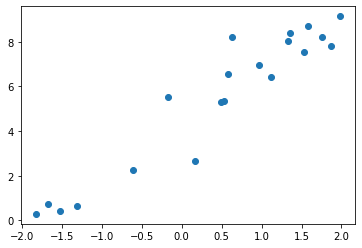

In [6]:
x = np.random.uniform(-2,2,20)
y = 2*x + 5 + np.random.normal(0,1,20)
plt.scatter(x,y)

In [7]:
x_tensor = torch.tensor(x)
y_tensor = torch.tensor(y)

In [8]:
def model(x,y):
    a = pyro.sample('a', dist.Normal(0., 5.))
    b = pyro.sample('b', dist.Normal(0.,5.))
    y = pyro.sample('y', dist.Normal(a*x + b, 1.), obs=y)
    return y

In [9]:
nuts_kernel = NUTS(model, adapt_step_size=True)
mcmc_run = MCMC(nuts_kernel, num_samples=1000, warmup_steps=1000)
mcmc_run.run(x_tensor,y_tensor)

Sample: 100%|██████████████████████████████████████| 2000/2000 [00:10, 189.35it/s, step size=7.85e-01, acc. prob=0.926]


In [10]:
posterior_a = mcmc_run.get_samples()['a']
posterior_b = mcmc_run.get_samples()['b']

In [11]:
pred = Predictive(model,{'a':posterior_a,'b':posterior_b},return_sites=["y"])

In [12]:
x_ = np.linspace(-2,2,100)
y_ = pred.get_samples(torch.tensor(x_),None)['y']

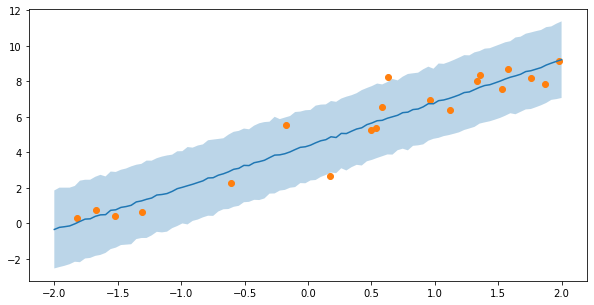

In [13]:
y_mean = y_.mean(0)
y_std = y_.std(0)
plt.figure(figsize=(10,5))
plt.plot(x_,y_mean)
plt.fill_between(x_,y_mean-y_std*2,y_mean+y_std*2,alpha=0.3)
plt.scatter(x,y)

In [14]:
def guide(x,y):
    a_loc = pyro.param('a_loc',torch.tensor(0.))
    b_loc = pyro.param('b_loc',torch.tensor(0.))
    a_scale = pyro.param('a_scale',torch.tensor(1.),constraints.positive)
    b_scale = pyro.param('b_scale',torch.tensor(1.),constraints.positive)
    pyro.sample('a',dist.Normal(a_loc,a_scale))
    pyro.sample('b',dist.Normal(b_loc,b_scale))

In [15]:
adam_params = {"lr": 0.001, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

n_steps = 2000
# do gradient steps
for step in range(n_steps):
    svi.step(x_tensor,y_tensor)

In [16]:
for name in pyro.get_param_store():
    print(name + ':{}'.format(pyro.param(name)))

a_loc:1.5989805459976196
b_loc:1.7343627214431763
a_scale:0.6598048210144043
b_scale:0.7270393371582031


In [17]:
y_pred = Predictive(model=model,guide=guide,num_samples=1000,return_sites=["y"])

In [18]:
x_ = torch.tensor(np.linspace(-2,2,100))
y_ = y_pred.get_samples(x_,None)

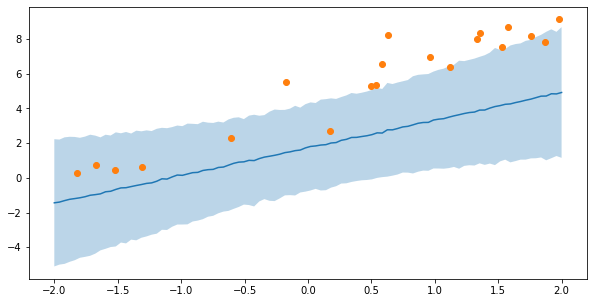

In [19]:
y_mean = y_['y'].mean(0).detach()
y_std = y_['y'].std(0).detach()
plt.figure(figsize=(10,5))
plt.plot(x_,y_mean)
plt.fill_between(x_,y_mean-y_std*2,y_mean+y_std*2,alpha=0.3)
plt.scatter(x,y)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions.constraints as constraints
import pyro 
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC,NUTS #MCMCで利用します
from pyro.optim import Adam #変分推論に利用します
from pyro.infer import SVI, Trace_ELBO #変分推論に利用します
from pyro.infer import Predictive # 予測分布の計算に利用します

In [2]:
n_sample = 20


n_CTT = 5
mu_CTT = 100
sigma_CTT = 5
ratio_Int_CTT = 0.2



n_ITT = 5
mu_ITT = 50
sigma_ITT = 5
ratio_Int_ITT = 0.5

In [14]:
def get_data_CTT():
    x0 = np.random.uniform(-60, 60,1)
    x = np.random.uniform(-10, 10, n_sample) + x0
    
    y0 = np.random.uniform(-20, 20,1)
    y = np.cos(np.deg2rad(x)) * np.random.normal(mu_CTT,sigma_CTT,len(x)) + 0.5*np.random.normal(0, abs(x), len(x))
    return x, y

(-80.0, 80.0)

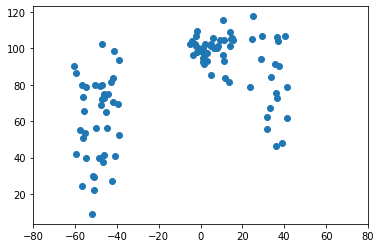

In [15]:
xs = []
ys = []
for i in range(n_CTT):
    x, y = get_data_CTT()
    xs.append(x)
    ys.append(y)

xs = np.array(xs).reshape(-1)
ys = np.array(ys).reshape(-1)

plt.scatter(xs, ys)
plt.xlim(-80, 80)

In [4]:
# x = np.random.uniform(-60, 60,120)
# y = np.cos(np.deg2rad(x)) * np.random.normal(mu_CTT,sigma_CTT,len(x)) + 0.5*np.random.normal(0, abs(x), len(x))
# plt.scatter(x,y)

In [5]:
x_tensor = torch.tensor(xs)
y_tensor = torch.tensor(ys)

In [6]:
def model(x,y):
    a = pyro.sample('a', dist.Normal(100., 50.))
    #b = pyro.sample('b', dist.Gamma(2.,0.5))
    b = pyro.sample('b', dist.Normal(0.,5))
    c = pyro.sample('c', dist.Gamma(2.,0.5))
    y = pyro.sample('y', dist.Normal(a*np.cos(np.deg2rad(x)), b*abs(x)+c), obs=y)
    return y

In [7]:
nuts_kernel = NUTS(model, adapt_step_size=True)
mcmc_run = MCMC(nuts_kernel, num_samples=1000, warmup_steps=1000)
mcmc_run.run(x_tensor,y_tensor)

Sample: 100%|███████████████████████████████████████| 2000/2000 [00:33, 60.45it/s, step size=3.92e-01, acc. prob=0.916]


In [8]:
posterior_a = mcmc_run.get_samples()['a']
posterior_b = mcmc_run.get_samples()['b']
posterior_c = mcmc_run.get_samples()['c']

In [9]:
pred = Predictive(model,{'a':posterior_a,'b':posterior_b,'c':posterior_c},return_sites=["y"])

In [10]:
x_ = np.linspace(-90,90,120)
y_ = pred.get_samples(torch.tensor(x_),None)['y']

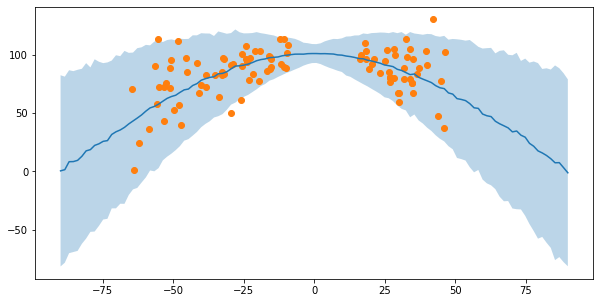

In [11]:
y_mean = y_.mean(0)
y_std = y_.std(0)
plt.figure(figsize=(10,5))
plt.plot(x_,y_mean)
plt.fill_between(x_,y_mean-y_std*2,y_mean+y_std*2,alpha=0.3)
plt.scatter(xs,ys)

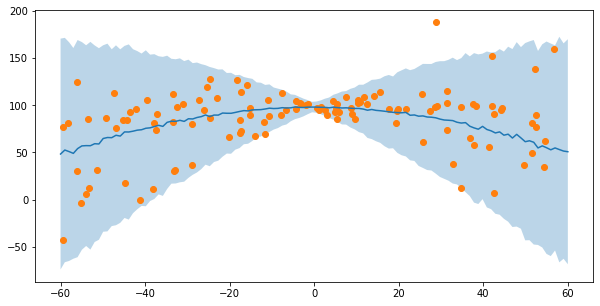

In [28]:
y_mean = y_.mean(0)
y_std = y_.std(0)
plt.figure(figsize=(10,5))
plt.plot(x_,y_mean)
plt.fill_between(x_,y_mean-y_std*2,y_mean+y_std*2,alpha=0.3)
plt.scatter(x,y)